In [16]:
import nest_asyncio
nest_asyncio.apply()
import cmdstanpy as sp
import numpy as np
from scipy.optimize import curve_fit
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import matplotlib.patches as mpatches
plt.rcParams["xtick.minor.visible"] =  True
plt.rcParams["ytick.minor.visible"] =  True
plt.rcParams["mathtext.fontset"]="cm"
plt.rcParams['errorbar.capsize'] = 3
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=22
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle']=':'
plt.rcParams['grid.color']='black'
plt.rcParams['axes.prop_cycle'] = cycler(color=['black', 'red', 'blue', 'green'])

import arviz as az
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("linear_model.txt",delimiter='\t',header=None)
data.columns=['x','y','dy']

In [3]:
def f(x,a,b):
    return a*np.cos(x)+b
popt, pcov = curve_fit(f,data['x'].values,data['y'].values,p0=[2,2],sigma=data['dy'].values)

In [4]:
model = sp.CmdStanModel(stan_file='./stan_file.stan')
print(model.code())

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/jakob/Documents/Studium/master_thesis/bayes/stan_file


data {
	int<lower=0> n;
	vector[n] x;
	vector[n] y;
	vector[n] dy;
}
parameters {
	real a;
	real b;
}

model {
	y ~ normal(b + a * cos(x), dy);
	a ~ normal(0,100);
	b ~ normal(0,100);
}
generated quantities {
	array[n] real y_tilde = normal_rng(b + a * cos(x),dy);
}



In [5]:
stan_data={'n':len(data['x'].values),
             'x':list(data['x'].values),
             'y':list(data['y'].values),
           'dy':list(data['dy'].values)
}

fit = model.sample(data=stan_data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3


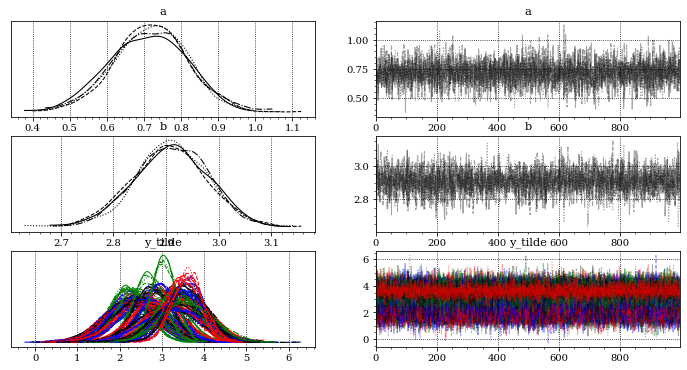

In [6]:
%%capture --no-display
warnings.filterwarnings('ignore')
az.plot_trace(fit)
plt.show()

In [7]:
summary=az.summary(fit)
samples=fit.draws_pd()
lower_a,upper_a = np.quantile(samples['a'],[0.025,0.975])
lower_b,upper_b = np.quantile(samples['b'],[0.025,0.975])


In [8]:
trace_thing=[]
for i in range(len(samples)):
    trace_thing.append(f(data['x'],samples['a'][i],samples['b'][i]))
    
lower_f=f(data['x'],lower_a,lower_b)
upper_f=f(data['x'],upper_a,upper_b)

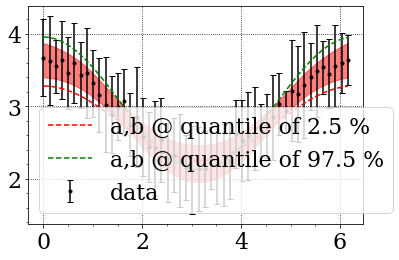

In [9]:
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',label='data')
plt.plot(data['x'],lower_f,'r--',label='a,b @ quantile of 2.5 %')
plt.plot(data['x'],upper_f,'g--',label='a,b @ quantile of 97.5 %')
az.plot_hdi(data['x'].values,trace_thing,hdi_prob=.95)
plt.legend()
plt.show()

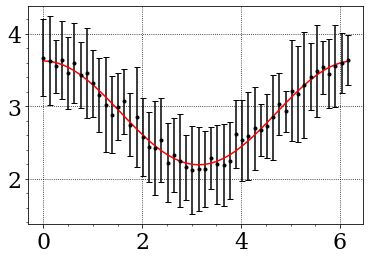

array([0.7158152 , 2.90910924])

In [10]:
yfit=f(data['x'],*popt)
plt.errorbar(x=data['x'],y=data['y'],yerr=data['dy'],fmt='.',color='black')
plt.plot(data['x'],yfit,'r-')
plt.show()
popt

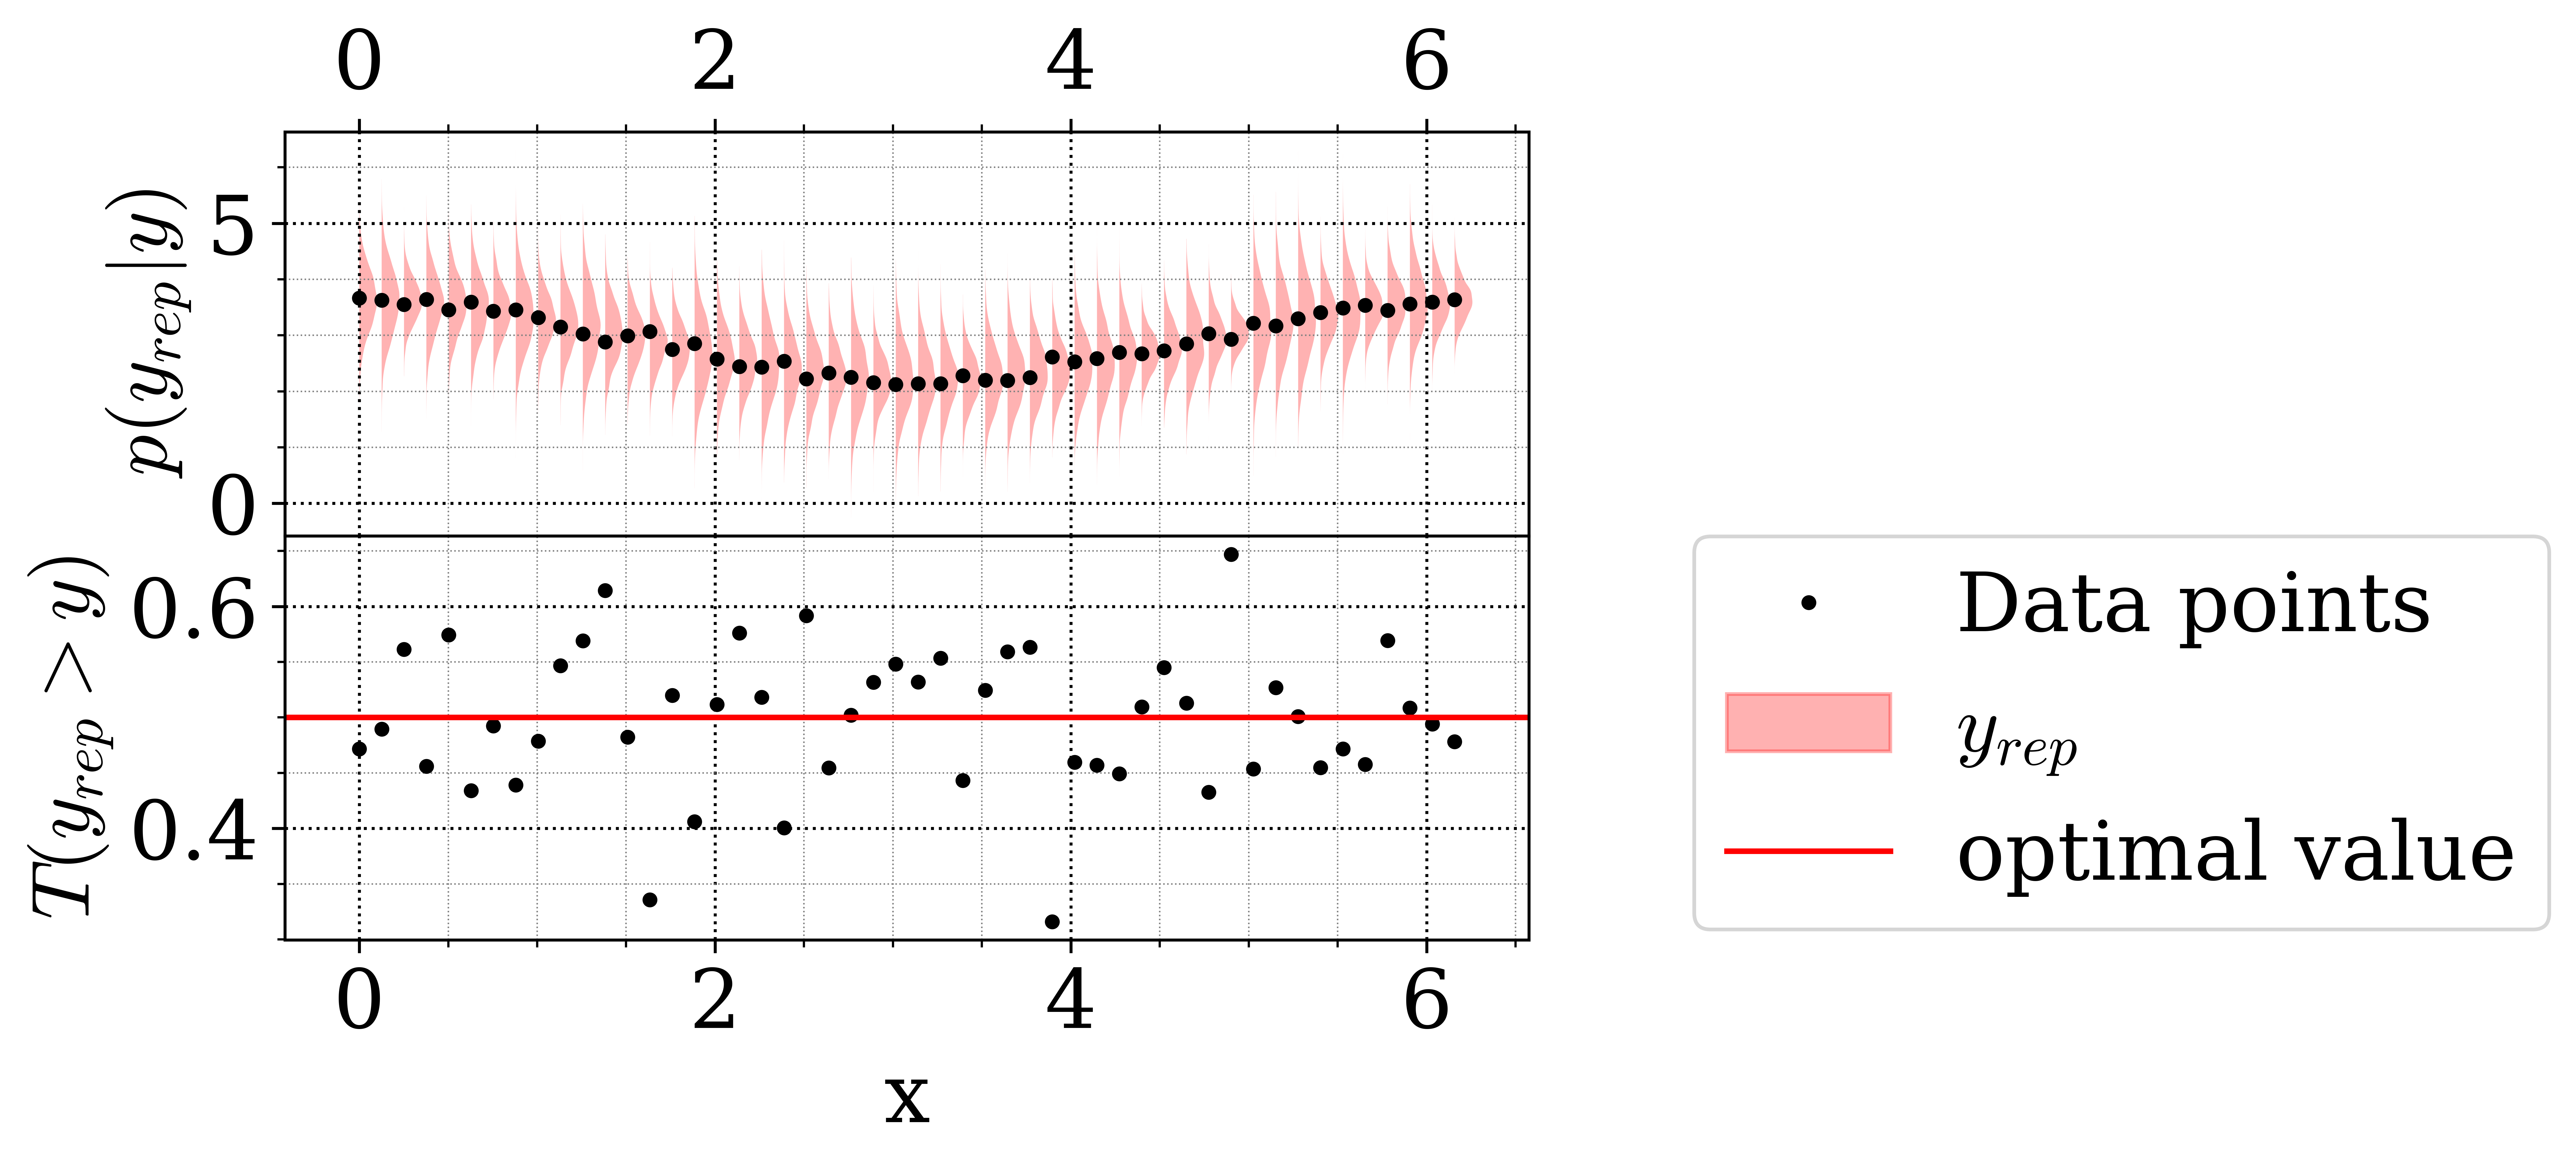

In [50]:
fig, (ax, ax1)=plt.subplots(nrows=2,sharex=True,dpi=1000)
ax.set_ylabel('$p(y_{rep}|y)$')
ax.xaxis.set_ticks_position("top")
ax.grid(which='minor',color='grey',lw='.4')
ax.plot(data['x'],data['y'],'.',label='Data points')
vp=ax.violinplot([samples[f'y_tilde[{i+1}]']for i in range(50)],data['x'],showmeans=False, showextrema=False, showmedians=False,widths=0.2)
for b in vp['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
y_arr=[samples[f'y_tilde[{i+1}]']for i in range(50)]
pvalue=[len([y for y in y_arr[i] if y>=data['y'][i]])/len(y_arr[i])for i in range(50)]
ax1.grid(which='minor',color='grey',lw='.4')
ax1.plot(data['x'],pvalue,'.')
ax1.axhline(y=0.5, color='r', linestyle='-',label='optimal value')
ax1.set_xlabel('x')
ax1.set_ylabel('$T(y_{rep}>y)$')
plt.subplots_adjust(wspace=0, hspace=0)
lines,labels = ax.get_legend_handles_labels() 
patch = mpatches.Patch(color='red',alpha=0.3, label='$y_{rep}$')
lines.append(patch)
lines1,labels1=ax1.get_legend_handles_labels()
lines+=lines1
# finally we invoke the legend (that you probably would like to customize...)
plt.legend(handles=lines,bbox_to_anchor=(1.1,1.1))
plt.savefig('plot.pdf',format='pdf',bbox_inches='tight',dpi=1000)


(array([ 2.,  0.,  2.,  4., 12., 10.,  8.,  9.,  1.,  2.]),
 array([0.316 , 0.3491, 0.3822, 0.4153, 0.4484, 0.4815, 0.5146, 0.5477,
        0.5808, 0.6139, 0.647 ]),
 <BarContainer object of 10 artists>)

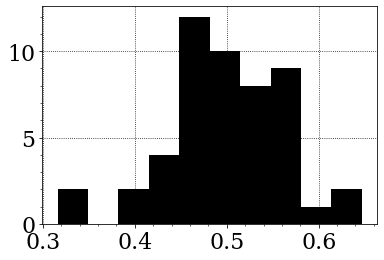

In [12]:
plt.hist(pvalue)

In [27]:
list=[sum(i,[])for i in [1,2,3,4,5]]

TypeError: 'int' object is not iterable

TypeError: can only concatenate list (not "str") to list